# Predicting the Stock Market

In this project, we work with data from the [S&P500 Index](https://en.wikipedia.org/wiki/S%26P_500_Index). 

We will use historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.

We will work with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in `sphist.csv`.

The columns of the dataset are:

- `Date` - the date of the record.
- `Open` - the opening price of the day (when trading starts).
- `High` - the highest trade price during the day.
- `Low` - the lowest trade price during the day.
- `Close` - the closing price for the day (when trading is finished).
- `Volume` - the number of shares traded.
- `Adj Close` - the daily closing price, adjusted retroactively to include any corporate actions. Read more [here](https://www.investopedia.com/terms/a/adjusted_closing_price.asp).

We use this dataset to develop a predictive model. We will train the model with data from `1950-2012`, and try to make predictions from `2013-2015`.

In [94]:
import pandas as pd
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('ggplot')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [95]:
#Let's start by reading in the dataset and converting the `Date` column to datetime format:

sp = pd.read_csv('sphist.csv')
sp['Date'] = pd.to_datetime(sp['Date'])

In [96]:
sp.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [97]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       16590 non-null  datetime64[ns]
 1   Open       16590 non-null  float64       
 2   High       16590 non-null  float64       
 3   Low        16590 non-null  float64       
 4   Close      16590 non-null  float64       
 5   Volume     16590 non-null  float64       
 6   Adj Close  16590 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 907.4 KB


In [98]:
sp['after'] = sp['Date'] > datetime(year=2015, month=4, day=1)
sp.head()

,Date,Open,High,Low,Close,Volume,Adj Close,after
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,True
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,True
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,True
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,True
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,True


In [99]:
#Let's sort the dataframe by the `Date` column in an ascending order

sp = sp.sort_values(by='Date', ascending = True)
sp.head()

,Date,Open,High,Low,Close,Volume,Adj Close,after
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66,False
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85,False
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93,False
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98,False
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08,False


## Generating indicators

Datasets taken from the stock market need to be handled differently than datasets from other sectors when it comes to making predictions. In a normal machine learning exercise, we treat each row as independent. Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and you cannot treat them as such.

This means we have to be extra careful to not inject "future" knowledge into past rows when we do training and prediction. Injecting future knowledge will make our model look good when we are training and testing it, but will make it fail in the real world. This is how many algorithmic traders lose money.

In [100]:
#Calculate the mean for the past 5, 30, 365 days
sp['day_5'] = sp['Close'].rolling(5).mean().shift(1)
sp['day_30'] = sp['Close'].rolling(30).mean().shift(1)
sp['day_365'] = sp['Close'].rolling(365).mean().shift(1)

#Calculate the STD for the past 5, 365 days
sp['std_5'] = sp['Close'].rolling(5).std().shift(1)
sp['std_365'] = sp['Close'].rolling(365).std().shift(1)

#Calculate the mean volume for the past 5, 365 days
sp['day_5_volume'] = sp['Volume'].rolling(5).mean().shift(1)
sp['day_365_volume'] = sp['Volume'].rolling(365).mean().shift(1)

#Calculate the STD of the average volume over the past five days
sp['5_volume_std'] = sp['day_5_volume'].rolling(5).std().shift(1)

In [101]:
sp.tail(10)

,Date,Open,High,Low,Close,Volume,Adj Close,after,day_5,day_30,day_365,std_5,std_365,day_5_volume,day_365_volume,5_volume_std
9,2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3.587980e+09,2086.590088,True,2071.523974,2061.892989,2033.605890,18.246940,64.911334,3.930538e+09,3.523622e+09,6.821252e+07
8,2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3.884930e+09,2089.139893,True,2078.204004,2064.197327,2034.018028,15.807754,64.768328,3.899886e+09,3.526334e+09,6.979154e+07
7,2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2.852940e+09,2088.870117,True,2085.943994,2067.045658,2034.432712,3.491188,64.634873,3.791402e+09,3.528961e+09,7.278537e+07
6,2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1.466840e+09,2090.110107,True,2087.002002,2070.199996,2034.835123,3.395982,64.514871,3.576712e+09,3.528637e+09,1.077890e+08
5,2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4.245030e+09,2080.409912,True,2088.776025,2072.408333,2035.199864,1.309055,64.449800,3.144458e+09,3.524258e+09,1.652146e+08
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,True,2087.024023,2073.984998,2035.531178,3.916109,64.370261,3.207544e+09,3.527800e+09,3.241733e+08
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,True,2090.231982,2076.283993,2035.914082,7.956808,64.352527,3.232372e+09,3.526090e+09,3.390314e+08
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,True,2088.306006,2077.908659,2036.234356,9.333599,64.277554,3.245514e+09,3.529468e+09,2.803620e+08
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,True,2080.456006,2078.931331,2036.507343,19.599946,64.121622,3.536224e+09,3.532802e+09,1.696382e+08
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,True,2080.771973,2080.237329,2036.869425,19.806136,64.058862,4.085838e+09,3.535838e+09,1.520693e+08


## Splitting up the data

Since we are computing indicators that use historical data, there are some rows where there is not enough historical data to generate them. Some of the indicators use `365 days` of historical data, and the dataset starts on `1950-01-03`. Thus, any rows that fall before `1951-01-03` do not have enough historical data to compute all the indicators. We need to remove these rows before we split the data.

In [102]:
sp = sp[sp['Date'] > datetime(year=1951, month=1, day=2)]

In [103]:
sp = sp.dropna(axis=0)

In [104]:
sp.head()

,Date,Open,High,Low,Close,Volume,Adj Close,after,day_5,day_30,day_365,std_5,std_365,day_5_volume,day_365_volume,5_volume_std
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,False,21.800,21.703333,19.447726,0.256223,1.790253,1196000.0,1.989479e+06,28982.753492
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,False,21.900,21.683000,19.462411,0.213659,1.789307,1176000.0,1.989041e+06,29339.393313
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,False,21.972,21.659667,19.476274,0.092574,1.788613,1188000.0,1.986932e+06,29610.808837
16221,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,False,21.960,21.631000,19.489562,0.115108,1.787659,1148000.0,1.982959e+06,27334.959301
16220,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,False,21.862,21.599000,19.502082,0.204132,1.786038,1142000.0,1.981123e+06,29879.759035


Let's now generate two new dataframes to use in making our algorithm. `train` should contain any rows in the data with a date less than `2013-01-01`. `test` should contain any rows with a date greater than or equal to `2013-01-01`.

In [105]:
train = sp[sp['Date'] < datetime(year=2013, month=1, day=1)]
test = sp[sp['Date'] > datetime(year=2013, month=1, day=1)]

## Making predictions

We are now ready to train the algorithum, make predictions and calculate the Mean Squared Error. Our target column is `Close`.

In [106]:
def predict(df, features):
    """Makes predictions on a Linear Regression model
        
        Args:
            df (dataframe) - dataframe which to use to train and test the model
            features (list) - list of columns on which to train the model
        Output:
            The MSE and RMSE for the model
    """
    lr = LinearRegression()
    lr.fit(train[features],train['Close'])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test['Close'], predictions)
    rmse = np.sqrt(mse)
    print("The MSE for features {} is:\n{:.2f}.".format(features, mse))
    print("The RMSE for features {} is:\n{:.2f}.".format(features, rmse))

In [107]:
features = ['day_5', 'day_30', 'day_365', 'std_5', 'std_365', 'day_5_volume', 'day_365_volume', '5_volume_std']
predict(sp, features)

The MSE for features ['day_5', 'day_30', 'day_365', 'std_5', 'std_365', 'day_5_volume', 'day_365_volume', '5_volume_std'] is:
494.66.
The RMSE for features ['day_5', 'day_30', 'day_365', 'std_5', 'std_365', 'day_5_volume', 'day_365_volume', '5_volume_std'] is:
22.24.


## Correlations

Let's see how the different columns in the dataset are correlated to `Close` column and see if we can improve the error metrics by removing some of the features.

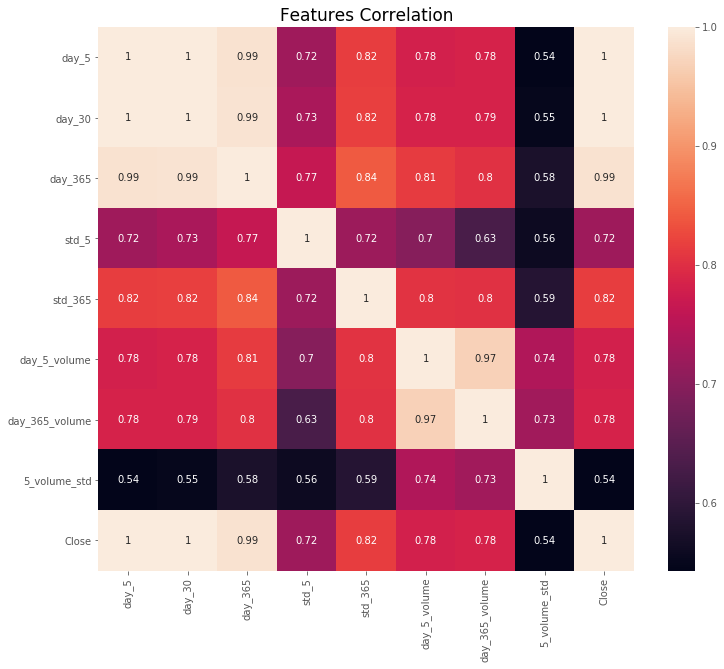

In [108]:
sp_copy = sp[['day_5','day_30', 'day_365', 'std_5', 'std_365', 'day_5_volume', 'day_365_volume','5_volume_std', 'Close']]

corr = sp_copy.corr()

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, annot=True)
plt.title('Features Correlation', size=17)
plt.show()

Let's keep only the features which have a correlation higher than 0.5 to the `Close` column. We will assign them to a list called `new_features`. We will then run the `predict` function again in order to see the error metrics will improved.

In [109]:
new_features = corr['Close'][corr['Close'] > 0.6].drop('Close').sort_values(ascending=False)
new_features

day_5             0.999793
day_30            0.999189
day_365           0.988870
std_365           0.816103
day_365_volume    0.784878
day_5_volume      0.780896
std_5             0.722414
Name: Close, dtype: float64

In [110]:
predict(sp, list(new_features.index))

The MSE for features ['day_5', 'day_30', 'day_365', 'std_365', 'day_365_volume', 'day_5_volume', 'std_5'] is:
493.91.
The RMSE for features ['day_5', 'day_30', 'day_365', 'std_365', 'day_365_volume', 'day_5_volume', 'std_5'] is:
22.22.


We see that there is a very minimal improvement in our error metrics. Let's now try different combinations of features.

In [111]:
for x in range(1,len(new_features)):
    predict(sp, list(new_features.index[:x]))
    print('-'*20)

The MSE for features ['day_5'] is:
493.27.
The RMSE for features ['day_5'] is:
22.21.
--------------------
The MSE for features ['day_5', 'day_30'] is:
493.85.
The RMSE for features ['day_5', 'day_30'] is:
22.22.
--------------------
The MSE for features ['day_5', 'day_30', 'day_365'] is:
493.73.
The RMSE for features ['day_5', 'day_30', 'day_365'] is:
22.22.
--------------------
The MSE for features ['day_5', 'day_30', 'day_365', 'std_365'] is:
493.95.
The RMSE for features ['day_5', 'day_30', 'day_365', 'std_365'] is:
22.23.
--------------------
The MSE for features ['day_5', 'day_30', 'day_365', 'std_365', 'day_365_volume'] is:
493.97.
The RMSE for features ['day_5', 'day_30', 'day_365', 'std_365', 'day_365_volume'] is:
22.23.
--------------------
The MSE for features ['day_5', 'day_30', 'day_365', 'std_365', 'day_365_volume', 'day_5_volume'] is:
494.84.
The RMSE for features ['day_5', 'day_30', 'day_365', 'std_365', 'day_365_volume', 'day_5_volume'] is:
22.24.
--------------------


We see that there is not much of a significant difference between the error metrics of the different feature combinations.

We do have some columns which cover similar information. Let's see what will happen if we make predictions using just one from each group, the one best correlated with `Close`:

- the mean closing for the last 5, 30, 365 days. Let's use the `day_5` column;
- the std for the last 5 and 365 dats. Let's use the `std_365` column;
- the mean volume from the last 5 and 365 days. Let's use the `day_365_volume` column.

In [112]:
three_features = ['day_5', 'std_365', 'day_365_volume']

predict(sp, three_features)

The MSE for features ['day_5', 'std_365', 'day_365_volume'] is:
493.94.
The RMSE for features ['day_5', 'std_365', 'day_365_volume'] is:
22.22.


Again, there is no significant difference in the error metrics.

## One day ahead prediction

Now, let's train the model to make predictions just one day ahead, based on the previous days.

In [113]:
def predict_one_day_ahead(df, row, features):
    """Makes predictions on a Linear Regression model, one day ahead
        
        Args:
            df (dataframe) - dataframe which to use to train and test the model
            row (dataframe row) - the row of the dataframe which will be predicted
            features (list) - list of columns on which to train the model
        
        Output:
            The RMSE for the model
    """
    
    train = df[df['Date'] < row['Date']]
    test = df[df['Date'] == row['Date']]
    
    if len(train) == 0:
        return np.nan
    else: 
        lr = LinearRegression()
        lr.fit(train[features], train['Close'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['Close'], predictions)
        rmse = np.sqrt(mse)
        return rmse

In [115]:
sp['one_day_ahead_prediction'] = sp.apply(lambda row: predict_one_day_ahead(sp, row, features), axis=1)

In [116]:
sp.head()

,Date,Open,High,Low,Close,Volume,Adj Close,after,day_5,day_30,day_365,std_5,std_365,day_5_volume,day_365_volume,5_volume_std,one_day_ahead_prediction
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,False,21.800,21.703333,19.447726,0.256223,1.790253,1196000.0,1.989479e+06,28982.753492,NaN
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,False,21.900,21.683000,19.462411,0.213659,1.789307,1176000.0,1.989041e+06,29339.393313,0.110000
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,False,21.972,21.659667,19.476274,0.092574,1.788613,1188000.0,1.986932e+06,29610.808837,0.195980
16221,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,False,21.960,21.631000,19.489562,0.115108,1.787659,1148000.0,1.982959e+06,27334.959301,0.186823
16220,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,False,21.862,21.599000,19.502082,0.204132,1.786038,1142000.0,1.981123e+06,29879.759035,0.055505


In [117]:
print('Mean RMSE for one day ahead predictions is {:.2f}.'.format(sp['one_day_ahead_prediction'].mean()))

Mean RMSE for one day ahead predictions is 5.49.


## Conclusion

In this project we used data from the S&P500 index ranging from 1950 to 2015. A Linear Regression model was trained to predict:

- the closing value for the days after 2013-01-01 based on the previous days;
- the closing value one day at a time based on the previous days.